In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_csv("new deaths dataset.csv", index_col='date', parse_dates=True)
print('shape',dataset.shape)
dataset.describe()

shape (500, 11)


,total_cases,new_cases,total_deaths,new_deaths,reproduction_rate,positive_rate,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,stringency_index
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,5.000000e+02,500.000000,500.000000,500.00000,500.000000
mean,52728.956000,204.206000,383.742000,1.646000,1.122480,0.068814,2.869641e+04,24776.272000,3920.140000,241.36000,47.446220
std,32793.093696,296.233164,281.213438,3.354876,0.263627,0.061634,1.613339e+05,133943.541915,39060.971015,3144.28997,12.460919
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.00000,0.000000
25%,26460.250000,0.000000,142.750000,0.000000,0.997500,0.023000,0.000000e+00,0.000000,0.000000,0.00000,38.890000
50%,50544.000000,89.000000,323.000000,0.000000,1.170000,0.045000,0.000000e+00,0.000000,0.000000,0.00000,44.440000
75%,89893.000000,281.250000,734.000000,2.000000,1.252500,0.100000,0.000000e+00,0.000000,0.000000,0.00000,52.780000
max,102103.000000,1583.000000,823.000000,28.000000,1.550000,0.319000,1.271393e+06,865422.000000,405971.000000,48252.00000,86.110000


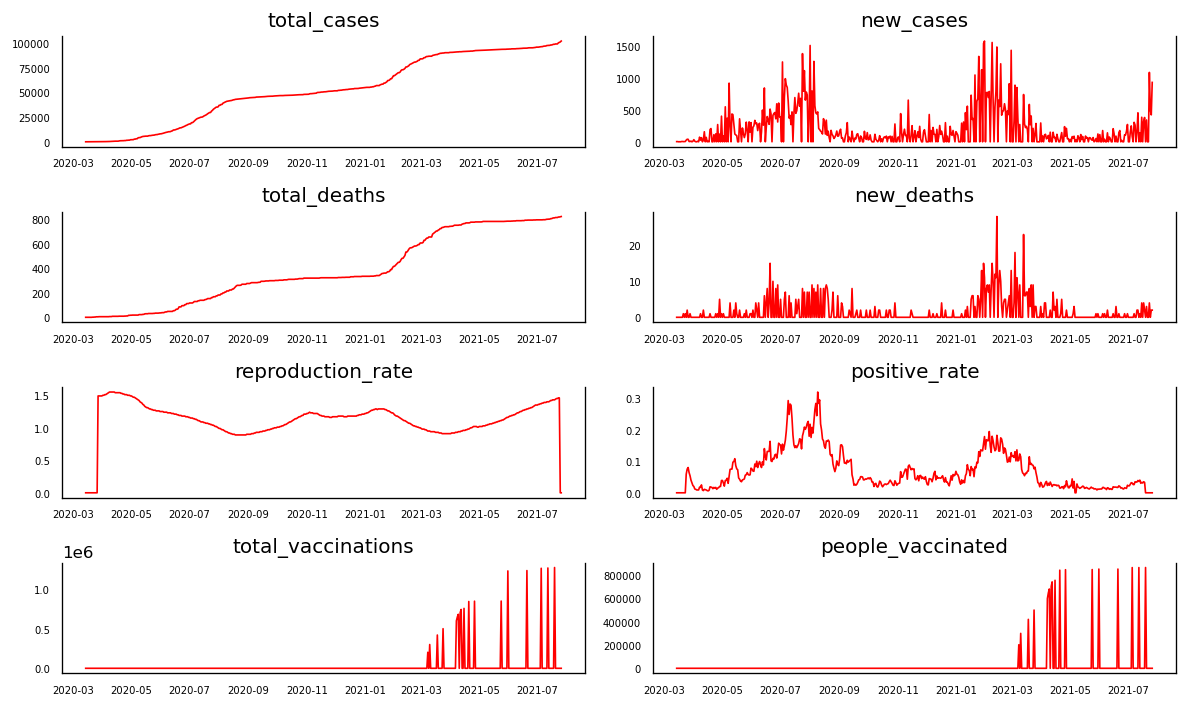

In [3]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = dataset[dataset.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(dataset.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [4]:
dataset2=dataset[['new_deaths','positive_rate']]
print(dataset.shape)

(500, 11)


In [5]:
train= dataset2.iloc[:-50]
test= dataset2.iloc[-50:]
print(train.shape,test.shape)

(450, 2) (50, 2)


In [6]:
model= VAR(train.diff()[1:])

In [7]:
sorted_order=model.select_order(maxlags=20)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -5.166      -5.147    0.005706      -5.159
1       -5.587      -5.531    0.003745      -5.565
2       -5.797      -5.702    0.003036      -5.760
3       -5.888      -5.755    0.002773      -5.835
4       -5.910      -5.740    0.002711      -5.843
5       -5.940      -5.732    0.002632      -5.858
6       -6.055      -5.808    0.002347      -5.957
7       -6.235     -5.950*    0.001961     -6.122*
8       -6.247      -5.925    0.001937      -6.120
9       -6.241      -5.882    0.001947      -6.099
10      -6.232      -5.835    0.001965      -6.075
11      -6.240      -5.805    0.001950      -6.068
12      -6.227      -5.754    0.001975      -6.041
13      -6.244      -5.733    0.001943      -6.042
14      -6.301      -5.752    0.001835      -6.085
15     -6.303*      -5.716   0.001831*      -6.072
16      -6.294      -5.670    0

In [8]:
var_model = VARMAX(train, order=(7,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

                                  Statespace Model Results                                 
Dep. Variable:     ['new_deaths', 'positive_rate']   No. Observations:                  450
Model:                                      VAR(7)   Log Likelihood                 133.590
                                       + intercept   AIC                           -201.180
Date:                             Tue, 21 Sep 2021   BIC                            -65.574
Time:                                     09:43:29   HQIC                          -147.733
Sample:                                 03-14-2020                                         
                                      - 06-06-2021                                         
Covariance Type:                               opg                                         
Ljung-Box (L1) (Q):             0.00, 0.08   Jarque-Bera (JB):      2923.53, 243.37
Prob(Q):                        0.99, 0.78   Prob(JB):                   0.00, 0.00
Hete

In [9]:
n_forecast = 50
predict = fitted_model.get_prediction(start=len(train),end=len(train) + n_forecast-1)#start="2021-06-07",end='2021-07-26')

predictions=predict.predicted_mean

In [10]:
predictions.columns=['new_deaths_predicted','positive_rate_predicted']
predictions

,new_deaths_predicted,positive_rate_predicted
2021-06-07,0.318418,0.015848
2021-06-08,0.535589,0.017733
2021-06-09,0.429808,0.019984
2021-06-10,0.562205,0.022186
2021-06-11,0.499421,0.022573
2021-06-12,0.553488,0.025548
2021-06-13,0.480780,0.025544
2021-06-14,0.515134,0.027461
2021-06-15,0.553208,0.028221
2021-06-16,0.564872,0.029891


In [11]:
test_vs_pred=pd.concat([test,predictions],axis=1)

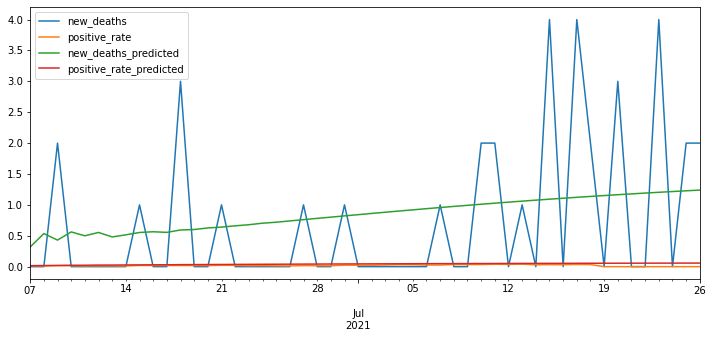

In [12]:
test_vs_pred.plot(figsize=(12,5))
plt.savefig('var new deaths')

In [13]:
from sklearn.metrics import mean_absolute_error
mae_new_deaths=mean_absolute_error(predictions['new_deaths_predicted'],test['new_deaths'])
print('Mean absolute error of new deaths is:',mae_new_deaths)

mae_positive_rate=(mean_absolute_error(predictions['positive_rate_predicted'],test['positive_rate']))
print('Mean absolute error of positive rate is:',mae_positive_rate)

Mean absolute error of new deaths is: 0.9250319972926975
Mean absolute error of positive rate is: 0.02339777702534039
